 # 01_Build a CALSPEC list of observable target from getCalspec package and generate sky trajectories and plot

- Author Sylvie Dagoret-Campagne
- Creation : August 22th 2023
- Update : August 23th 2023 : all bug corrected
- Update : August 24th 2023 : add UTC time to plots
- Update : August 29th 2023 : preselection fo target activated by a FLAG
- Update : August 29th 2023 : Correct a big bug on Longitide angle and ra selection
- Update : August 30th 2023 : DarkTimeIndex 
- update : December 17th 2024 : Prepare observation for January 6th 2025
- last update : December 21th 2024 : conda_py310

## Ckeck on airmass.org : https://airmass.org/

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import astropy_mpl_style, quantity_support
plt.style.use(astropy_mpl_style)
quantity_support()
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

from matplotlib.dates import (AutoDateLocator, YearLocator, MonthLocator,
                              DayLocator, WeekdayLocator, HourLocator,
                              MinuteLocator, SecondLocator, MicrosecondLocator,
                              RRuleLocator, rrulewrapper, MONTHLY,
                              MO, TU, WE, TH, FR, SA, SU, DateFormatter,
                              AutoDateFormatter, ConciseDateFormatter)

%matplotlib inline
import pandas as pd

In [2]:
import astropy.units as u
from astropy.coordinates import AltAz, EarthLocation, SkyCoord
from astropy.coordinates import Angle
from astropy.time import Time, TimezoneInfo,TimeDelta
from astropy.coordinates import Longitude,Latitude

In [3]:
import datetime as dt
from datetime import datetime
import timezonefinder, pytz
from calendar import monthrange
import calendar

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [5]:
from astroquery.simbad import Simbad

In [6]:
# to view the list of VOTABLE
# Simbad.list_votable_fields()

In [7]:
Simbad.add_votable_fields('sptype')
Simbad.add_votable_fields('flux(U)') # add the Vega unit Magnitude 
Simbad.add_votable_fields('flux(B)') # add the Vega unit Magnitude 
Simbad.add_votable_fields('flux(V)') # add the Vega unit Magnitude 
Simbad.add_votable_fields('flux(R)') # add the Vega unit Magnitude 
Simbad.add_votable_fields('flux(I)') # add the Vega unit Magnitude 
#Simbad.add_votable_fields('flux_unit(V)')
#Simbad.add_votable_fields('flux_unit(I)')
#Simbad.add_votable_fields('flux_system(V)')
#Simbad.add_votable_fields('flux_system(I)')
#Simbad.add_votable_fields('ubv')  # Johnson UBV system

In [8]:
plt.rcParams["axes.labelsize"]="large"
plt.rcParams["axes.linewidth"]=2.0
plt.rcParams["xtick.major.size"]=8
plt.rcParams["ytick.major.size"]=8
plt.rcParams["ytick.minor.size"]=5
plt.rcParams["xtick.labelsize"]="large"
plt.rcParams["ytick.labelsize"]="large"

plt.rcParams["figure.figsize"]=(12,8)
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.titleweight'] = 'bold'
#plt.rcParams['axes.facecolor'] = 'blue'
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'
plt.rcParams['lines.markeredgewidth'] = 0.3 # the line width around the marker symbol
plt.rcParams['lines.markersize'] = 5  # markersize, in points
plt.rcParams['grid.alpha'] = 0.75 # transparency, between 0.0 and 1.0
plt.rcParams['grid.linestyle'] = '-' # simple line
plt.rcParams['grid.linewidth'] = 0.4 # in points
plt.rcParams['font.size'] = 13

In [9]:
def CalculateBounds(theta,thetamin,thetamax):
    """
    Handle the boundaries of angles
    
    parameters:
        theta : the input angle in degree to test
        thetamin: lower bound angle
        thetamax: upper bound angle
    """
    
    theta_min_angle = Longitude(thetamin,unit=u.degree)
    theta_max_angle = Longitude(thetamax,unit=u.degree)
    theta_angle = Longitude(theta,unit=u.degree)
    
    
    #print("longitude angles",theta_angle,theta_min_angle,theta_max_angle)
    
    
    wrap = 0
    
    if theta_min_angle.degree < theta_max_angle.degree:
        wrap = 360 * u.deg
    else:
        wrap = 180 * u.deg
        
    theta_min_angle.wrap_angle = wrap
    theta_max_angle.wrap_angle = wrap
    theta_angle.wrap_angle = wrap
       
    #print("wrap",wrap,"theta=",theta_angle,"theta_min=",theta_min_angle,"theta_max",theta_max_angle)
    return theta_angle.is_within_bounds(theta_min_angle,theta_max_angle)
    

## CALSPEC

Use the package getCalspec to work on CALSPEC object

https://github.com/LSSTDESC/getCalspec/blob/main/getCalspec/getCalspec.py

https://github.com/LSSTDESC/getCalspec/tree/main/getCalspec

In [10]:
# to get all Calspec data in one time in cache, write¶
from getCalspec.rebuild import rebuild_cache
# rebuild_cache()

In [11]:
# When the STSC webpage is updated, it might be necessary to rebuild the calspec_data/calspec.csv table and the cache:¶
from getCalspec.rebuild import rebuild_tables, rebuild_cache
#rebuild_tables()
#rebuild_cache()

### Retrieve all calspec

Try directly reading the table from getCalspec package. If not possible, read directly this table from the table stored in filename = "../../calspec_data/calspec.csv"

In [12]:
from getCalspec.getCalspec import getCalspecDataFrame

In [13]:
flag_getscalspec = False
try:
    df = getCalspecDataFrame()
    flag_getscalspec = True
except:
    filename = "../../calspec_data/calspec.csv"
    df = pd.read_csv(filename,index_col=0)  
finally:
    print(f">>>> getCalspec : {flag_getscalspec} <<<<<")
    print(df.head())   

>>>> getCalspec : True <<<<<
   Unnamed: 0 Star_name   Sp_T      V    B_V     Name     Model          STIS  \
0           0   109 VIR  A0III   3.73  -0.01   109vir  _mod_003     _stis_003   
1           1    10 LAC    O9V   4.88  -0.21    10lac  _mod_005     _stis_007   
2           2  16 CYG B    G3V   6.20   0.66   16cygb  _mod_004     _stis_004   
3           3    18 SCO    G2V   5.50   0.65    18sco  _mod_005     _stis_005   
4           4   1732526    A4V  12.53   0.12  1732526  _mod_005  _stisnic_007   

  Var_(%)            RA          Decl    Vr      PM    PM.1  \
0     NaN  14 46 14.925  +01 53 34.38  -6.1 -114.03  -22.13   
1   <0.23  22 39 15.679  +39 03 00.97 -10.0   -0.32   -5.46   
2   <0.21  19 41 51.973  +50 31 03.09 -27.7 -134.79 -162.49   
3     NaN  16 15 37.270  -08 22 09.98  11.9  232.16 -495.37   
4    1.40  17 32 52.630  +71 04 43.12   NaN    0.22   -2.71   

               Simbad_Name  Alt_Simbad_Name  Astroquery_Name Alt_Star_name  \
0                 HD130109 

In [14]:
df

,Unnamed: 0,Star_name,Sp_T,V,B_V,Name,Model,STIS,Var_(%),RA,Decl,Vr,PM,PM.1,Simbad_Name,Alt_Simbad_Name,Astroquery_Name,Alt_Star_name,HD_name
0,0,109 VIR,A0III,3.73,-0.01,109vir,_mod_003,_stis_003,NaN,14 46 14.925,+01 53 34.38,-6.1,-114.03,-22.13,HD130109,NaN,* 109 VIR,NaN,HD130109
1,1,10 LAC,O9V,4.88,-0.21,10lac,_mod_005,_stis_007,<0.23,22 39 15.679,+39 03 00.97,-10.0,-0.32,-5.46,NaN,NaN,* 10 LAC,NaN,HD214680
2,2,16 CYG B,G3V,6.20,0.66,16cygb,_mod_004,_stis_004,<0.21,19 41 51.973,+50 31 03.09,-27.7,-134.79,-162.49,HD186427,NaN,* 16 CYG B,NaN,HD186427
3,3,18 SCO,G2V,5.50,0.65,18sco,_mod_005,_stis_005,NaN,16 15 37.270,-08 22 09.98,11.9,232.16,-495.37,HD146233,NaN,* 18 SCO,NaN,HD146233
4,4,1732526,A4V,12.53,0.12,1732526,_mod_005,_stisnic_007,1.40,17 32 52.630,+71 04 43.12,NaN,0.22,-2.71,2MASS J17325264+7104431,TYC 4424-1286-1,TYC 4424-1286-1,NaN,NaN
5,5,1740346,A6V,12.48,0.20,1740346,NaN,_stisnic_005,NaN,17 40 34.679,+65 27 14.77,NaN,-5.72,-3.44,2MASS J17403468+6527148,TYC 4207-219-1,TYC 4207-219-1,NaN,NaN
6,6,1743045,A8III,13.52,0.28,1743045,_mod_005,_stisnic_007,<1.32,17 43 04.486,+66 55 01.66,NaN,1.10,-2.79,2MASS J17430448+6655015,NaN,2MASS J17430448+6655015,NaN,NaN
7,7,1757132,A3V,12.01,-0.10,1757132,_mod_005,_stiswfc_004,<0.37,17 57 13.233,+67 03 40.77,NaN,0.41,-14.03,2MASS J17571324+6703409,TYC 4212-455-1,TYC 4212-455-1,NaN,NaN
8,8,1802271,A2V,11.53,0.02,1802271,_mod_005,_stiswfcnic_004,<0.82,18 02 27.163,+60 43 35.54,NaN,5.40,2.17,2MASS J18022716+6043356,TYC 4201-1542-12,BPS BS 17447-0067,NaN,NaN
9,9,1805292,A4V,12.28,0.14,1805292,_mod_004,_stisnic_006,<0.49,18 05 29.275,+64 27 52.13,NaN,-1.64,10.06,2MASS J18052927+6427520,TYC 4209-1396-1,TYC 4209-1396-1,NaN,NaN


## Calculate the Visibility of the star

### Observation date

In [15]:
NYEAR=2025
NMONTH=1
NDAY=12

### Selection of object

    HD185975 20:28:18 -87:28:19.9 type G3V, V=8.10

    HD14943 02:22:54 -51:05:31.7 type A5V, V=5.91

    HD38666 05:46:00 -32:18:23.2  type O9.5V, V=5.2

    HD60753 07:33:27 -50:35:03.3  type B3IV, V=6.7 

    HD146233 16:15:37 -08:22:10.0  type G2V, V=5.5

In [16]:
FLAG_PRESELECTION_TARGET = False
preselected_target_names = np.array(["HD185975","HD14943","HD38666","HD60753","HD146233"])

### Examples from https://docs.astropy.org/en/stable/generated/examples/coordinates/plot_obs-planning.html

In [17]:
m33 = SkyCoord.from_name('M33')

In [18]:
bear_mountain = EarthLocation(lat=41.3*u.deg, lon=-74*u.deg, height=390*u.m)
utcoffset = -4*u.hour  # Eastern Daylight Time
time = Time('2025-1-06 23:00:00') - utcoffset

In [19]:
m33altaz = m33.transform_to(AltAz(obstime=time,location=bear_mountain))
print(f"M33's Altitude = {m33altaz.alt:.2}")

M33's Altitude = 4.6e+01 deg


## My Location here in Paris

In summer the UTC offset at my location is + 2 H

In [20]:
mylat = 48.8534
mylong = 2.3488

In [21]:
paris = EarthLocation(lat=mylat*u.deg, lon=mylong*u.deg, height=0*u.m)
utcoffset = 2*u.hour  # CET
time = Time('2025-1-06 23:00:00') - utcoffset

In [22]:
tf = timezonefinder.TimezoneFinder()
mytimezone_str = tf.certain_timezone_at(lat=mylat, lng=mylong)

In [23]:
mytimezone_str

'Europe/Paris'

In [24]:
if mytimezone_str is None:
    print("Could not determine my time zone")
else:
    # Display the current time in that time zone
    
    
    timezone = pytz.timezone(mytimezone_str)
    timezone0 = pytz.timezone('UTC')
    
    dt = datetime.utcnow()
    timeParis_now = datetime.now(timezone)
    utc_offset =  timezone.utcoffset(dt)
    
    print("\t - The UTC Time now %s" % dt)
    print("\t - The actual time in %s is %s" % (mytimezone_str, dt + timezone.utcoffset(dt)))
    print(f"\t - the UTC offset in my zone {mytimezone_str} is {utc_offset}")

	 - The UTC Time now 2024-12-21 14:44:06.254936
	 - The actual time in Europe/Paris is 2024-12-21 15:44:06.254936
	 - the UTC offset in my zone Europe/Paris is 1:00:00


/var/folders/79/hrybm_4s0zjd4jsb7lp_trhh0000gp/T/ipykernel_98739/3671942776.py:10: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  dt = datetime.utcnow()


### For LSST

### Observation location

In [25]:
LSSTNAME='Cerro Pachon'
lsst_location=EarthLocation.of_site(LSSTNAME)
longitude=lsst_location.lon
latitude=lsst_location.lat
altitude=lsst_location.height

In [26]:
cerro_pachon = EarthLocation(lat=latitude.degree*u.deg, lon=longitude.degree*u.deg, height=altitude)

### Determination of UTC offset from TimeZone in Chile

In [27]:
tf = timezonefinder.TimezoneFinder()
timezone_str = tf.certain_timezone_at(lat=latitude.degree, lng=longitude.degree)

In [28]:
print(f"Time zone at Rubin LSST Observatory: {timezone_str}")

Time zone at Rubin LSST Observatory: America/Santiago


In [29]:
if timezone_str is None:
    print("Could not determine the time zone")
else:
    # Display the current time in that time zone
    
    #tz = pytz.timezone('Europe/Berlin')
    #berlin_now = datetime.now(tz)
    
    timezone = pytz.timezone(timezone_str)
    timezone0 = pytz.timezone('UTC')
    
    dt = datetime.utcnow()
    timeChile_now = datetime.now(timezone)
    utc_offset =  timezone.utcoffset(dt)
    
    print("The UTC Time now %s" % dt)
    print("The actual time in %s is %s" % (timezone_str, dt + timezone.utcoffset(dt)))

    print("\t - The UTC Time now %s" % dt)
    print("\t - The actual time in %s is %s" % (timezone_str, dt + timezone.utcoffset(dt)))
    print(f"\t - the UTC offset in LSST zone {timezone_str} is {utc_offset}")

The UTC Time now 2024-12-21 14:44:06.537395
The actual time in America/Santiago is 2024-12-21 11:44:06.537395
	 - The UTC Time now 2024-12-21 14:44:06.537395
	 - The actual time in America/Santiago is 2024-12-21 11:44:06.537395
	 - the UTC offset in LSST zone America/Santiago is -1 day, 21:00:00


/var/folders/79/hrybm_4s0zjd4jsb7lp_trhh0000gp/T/ipykernel_98739/4137192889.py:12: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  dt = datetime.utcnow()


In [30]:
utcoffset_number = timezone.utcoffset(dt).total_seconds()/60./60.
print("The UTC offset in Chile is ",utcoffset_number," hours")

The UTC offset in Chile is  -3.0  hours


### the TimezoneInfo object from astropy

- https://docs.astropy.org/en/stable/api/astropy.time.TimezoneInfo.html
- create the TimezoneInfo object required for sideral time 

In [31]:
#utc = TimezoneInfo()    # Defaults to UTC
#utc_plus_one_hour = TimezoneInfo(utc_offset=1*u.hour)  # UTC+1

In [32]:
tz_utc_minus_xx_hours = TimezoneInfo(utc_offset = int(utcoffset_number)*u.hour)

### Night of observation

- creation of an observation date chosen very close to the local midnight from the chosen NYEAR,NMONTH,NDAY
- Note we provide the **tz_utc_minus_xx_hours** which provide the UTC offset of the site

In [33]:
# datetime at local midnight in the timezone of Chile by providing the right TimezoneInfo() object set at site Timezone
night_obs = datetime(NYEAR, NMONTH, NDAY, 0, 0)
night_obs_midnight = datetime(NYEAR, NMONTH, NDAY, 23, 59,59,tzinfo = tz_utc_minus_xx_hours)

In [34]:
night_obs_str = night_obs.strftime("%Y-%m-%d %H:%M:%S")
print(f"Night of Observation : {night_obs_str}")

Night of Observation : 2025-01-12 00:00:00


In [35]:
#check the string of the date
night_obs_midnight_str = night_obs_midnight.strftime("%Y-%m-%d %H:%M:%S")
night_obs_midnight_str
print(f"Midnight of Night of Observation : {night_obs_midnight_str}")

Midnight of Night of Observation : 2025-01-12 23:59:59


### Compute UTC and Sideral Time at local midnight

We check here that the offset in time between UTC and Chile time is 3 hours

### TimezoneInfo object from astropy
https://docs.astropy.org/en/stable/api/astropy.time.TimezoneInfo.html

In [36]:
#utc = TimezoneInfo()    # Defaults to UTC
#utc_plus_one_hour = TimezoneInfo(utc_offset=1*u.hour)  # UTC+1

In [37]:
tz_utc = TimezoneInfo() 
print("\t - Local time in Santiago in (GMT-3) in winter : ",night_obs_midnight)
print("\t - Time in UTC at the Local Time above         : ",night_obs_midnight.astimezone(tz_utc))

	 - Local time in Santiago in (GMT-3) in winter :  2025-01-12 23:59:59-03:00
	 - Time in UTC at the Local Time above         :  2025-01-13 02:59:59+00:00


In [38]:
utc_minus_three_hour = TimezoneInfo(utc_offset = utcoffset_number *u.hour)  # UTC-3

### Sidereal time at LSST site 

- https://docs.astropy.org/en/stable/time/index.html
- we compute here the local sideral time at midnight local time
- we need to provide the utc offset  from the object TimezoneInfo required later to compute the local siteral time

#### Sidereal time and angle at local time midnight

- this calculation has been checked in Stellarium

In [39]:
# the sidereal time is constructed from 1) local clock wall time, 2) the UTC timezone 3) and the location of observation site on earth 
t_lsst = Time(night_obs_midnight.astimezone(tz_utc), scale='utc',location = lsst_location)
t_sidereal_lsst = t_lsst.sidereal_time('apparent')  
print("Sideral Time at LSST midnight:",t_sidereal_lsst)

Sideral Time at LSST midnight: 5h48m26.42863318s


#### The Sideral angle is measured from the meridian ( westward in north hemisphere)

In [40]:
print("Sidereal Time angle at LSST midnight:",Angle(t_sidereal_lsst).to(u.degree))

Sidereal Time angle at LSST midnight: 87d06m36.42949764s


In [41]:
print("Sidereal Time angle at LSST midnight:",Angle(t_sidereal_lsst).degree)

Sidereal Time angle at LSST midnight: 87.11011930490038


## Filter Obervable targets according RA and magnitude and culmination angle
$$
HA = LST - RA
$$

where $HA$ means Hour Angle, $LST$ means Local sidereal time and $RA$ means Right ascension
- $-6H<HA<+6H \longrightarrow  LST-6H <RA< LST+6H $ 
- Select the target which Right-Asccention is +/- 6 hours from the sideral time
- The culmination Hour angle at the meridian must not be less than -6H to + 6H

#### - Criteria on Margin Angle

- Strange but I cannot have a larger margin : need to understand

In [108]:
MarginAngle = Angle(6.0,u.hour)
MarginAngle

<Angle 6. hourangle>

$$
RA = LST - HA(margin\; Angle)
$$

In [109]:
#calculate tdege range of RA target to be visible within the MarginAngle
#ra_min = (t_sidereal_lsst - MarginAngle).degree
#ra_max = (t_sidereal_lsst + MarginAngle).degree
ra_min = Longitude((t_sidereal_lsst - MarginAngle).degree,unit=u.deg)
ra_max = Longitude((t_sidereal_lsst + MarginAngle).degree,unit=u.deg)

In [110]:
ra_min

<Longitude 357.1101193 deg>

In [45]:
ra_max

<Longitude 184.6101193 deg>

In [46]:
#ra_min_angle = Angle(ra_min,u.degree)
#ra_max_angle = Angle(ra_max,u.degree)
ra_min_angle = Longitude(ra_min,u.degree)
ra_max_angle = Longitude(ra_max,u.degree)
#ra_min_angle.wrap_angle = 180 * u.deg
#ra_max_angle.wrap_angle = 180 * u.deg

In [47]:
ra_min_angle.degree

np.float64(349.61011930490037)

In [48]:
ra_max_angle.degree

np.float64(184.61011930490037)

#### - Criteria on culmination angle

- The culmination angle is obtained when HA = 0, then RA = LST

In [49]:
culmin_angle_min = 40

#### - Criteria on magnitude in V

In [50]:
magLim = 12.

### Algo for the selection of the target wrt RA selection , culmination angle, 

In [51]:
all_flag_select = []

# numeric collections
all_ra_angles_deg = []
all_dec_angles_deg = []
all_altmax_angle_deg = []
all_zenithmin_angle_deg = []
all_magV = []

# loop on each entries in the df table to calculate angles
for index, row in df.iterrows(): 
    target_name = row["Star_name"]
    hd_name = row["HD_name"]
    
    # compute numeric values for ra-dec
    ra_angle = Longitude(row['RA'],unit = u.hour) # the RA angle is a string in Sexagesimal hours
    #ra_angle.wrap_angle = 180 * u.deg
    
    dec_angle = Angle(row["Decl"],unit = u.deg) # the dec angle is a string in degrees 

    
    # compute the culmination angle from the zenith angle
    # North hemisphere
    if latitude.deg >= 0:
        if dec_angle.deg >= latitude.deg:
            zenith_angle =   dec_angle - latitude
        else:
            zenith_angle = latitude - dec_angle
    # south hemisphere
    else:
        if dec_angle.deg < latitude.deg :
            zenith_angle =   latitude - dec_angle 
        else:
            zenith_angle =   dec_angle - latitude 
        
    culmination_angle = Angle(90.0, unit = u.deg) - zenith_angle

    
    # don't remember why I do this
    if (index !=12) and (index !=13) and (index!= 95):
        magV = float(row["V"])
    else:
        if index == 12:
            magV = 12.47
        elif index==13:
            magV = 13.80
        elif index == 95:
            magV = 17.01
            
             
    all_ra_angles_deg.append(ra_angle.degree)
    all_dec_angles_deg.append(dec_angle.degree)
    all_altmax_angle_deg.append(culmination_angle.degree) 
    all_zenithmin_angle_deg.append(zenith_angle.degree )
    all_magV.append(magV)
  
    # test on ra angle
    #flag1 = ra_angle.is_within_bounds(ra_min_angle,ra_max_angle)
    flag1 = CalculateBounds(ra_angle.degree,ra_min_angle.degree,ra_max_angle.degree)
    
    flag2 = (magV < magLim)
    flag3 = False
    
    # test on culmination angle
    if culmination_angle.degree > culmin_angle_min :
        flag3 = True
        
    
    flag = flag1 & flag2 & flag3
    
    if target_name == "HD185975":
        # keep polar star
        flag = True

    # test on preselected names
    if FLAG_PRESELECTION_TARGET:
        if target_name in preselected_target_names:
          
            if not flag:
                print(f"BE CAREFULL , a rejected target {target_name} is in Pre-Selection list, PLEASE CHECK")
            flag =True
        else:
            if flag:
                print(f"BE CAREFULL , a good target {target_name} is not in Pre-Selection list, PLEASE CHECK")
            flag = False
        
    
    if flag:
        print(f"{index}, {target_name} ({hd_name}), RA = {ra_angle.hour:.2f} , DEC = {dec_angle.degree:.2f} , RA-MIN-MAX = {ra_min_angle.deg:.1f}-{ra_max_angle.deg:.1f},zenith_angle = {zenith_angle.degree:.2f}  culmination angle = {culmination_angle.degree:.2f} , magV = {magV} , flag_select = {flag}")
   
    all_flag_select.append(flag)                

55, HD185975 (HD185975), RA = 20.47 , DEC = -87.47 , RA-MIN-MAX = 349.6-184.6,zenith_angle = 57.23  culmination angle = 32.77 , magV = 8.1 , flag_select = True


## Add calculated numerical values to the pandas table

In [52]:
df["ra_deg"] = all_ra_angles_deg
df["dec_deg"] = all_dec_angles_deg 
df["alt_max"] = all_altmax_angle_deg
df["zenith_min"] = all_zenithmin_angle_deg
df["magV"] = all_magV 

### Example for debug

In [53]:
cut = df["Star_name"] == "HD205905"

In [54]:
df[cut]

,Unnamed: 0,Star_name,Sp_T,V,B_V,Name,Model,STIS,Var_(%),RA,Decl,Vr,PM,PM.1,Simbad_Name,Alt_Simbad_Name,Astroquery_Name,Alt_Star_name,HD_name,ra_deg,dec_deg,alt_max,zenith_min,magV
58,58,HD205905,G2V,6.74,0.62,hd205905,_mod_007,_stis_009,0.26,21 39 10.151,-27 18 23.67,-17.0,384.1,-83.96,NaN,NaN,HD 205905,NaN,HD205905,324.792296,-27.306575,87.065833,2.934167,6.74


## Apply all selection cuts on RA, culmination and magnitude

In [55]:
df["select"] = all_flag_select
cut = df["select"] == True

t=df[cut]
NTargets=len(t)

In [56]:
t

,Unnamed: 0,Star_name,Sp_T,V,B_V,Name,Model,STIS,Var_(%),RA,Decl,Vr,PM,PM.1,Simbad_Name,Alt_Simbad_Name,Astroquery_Name,Alt_Star_name,HD_name,ra_deg,dec_deg,alt_max,zenith_min,magV,select
55,55,HD185975,G3V,8.10,0.68,hd185975,_mod_004,_stis_007,NaN,20 28 18.740,-87 28 19.94,-19.0,169.76,-56.99,NaN,NaN,HD 185975,NaN,HD185975,307.078083,-87.472206,32.768536,57.231464,8.1,True


### Must reindex the table

In [57]:
t = t.reset_index(drop=True)

In [58]:
t

,Unnamed: 0,Star_name,Sp_T,V,B_V,Name,Model,STIS,Var_(%),RA,Decl,Vr,PM,PM.1,Simbad_Name,Alt_Simbad_Name,Astroquery_Name,Alt_Star_name,HD_name,ra_deg,dec_deg,alt_max,zenith_min,magV,select
0,55,HD185975,G3V,8.10,0.68,hd185975,_mod_004,_stis_007,NaN,20 28 18.740,-87 28 19.94,-19.0,169.76,-56.99,NaN,NaN,HD 185975,NaN,HD185975,307.078083,-87.472206,32.768536,57.231464,8.1,True


In [59]:
# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NTargets)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NTargets), alpha=1)

## Compute Target location before computing their sky trajectory

In [60]:
all_target_names = t["Astroquery_Name"]
print("order in selected target location")
print(all_target_names)
selected_target_locations = [ SkyCoord.from_name(target_name) for target_name in all_target_names]

order in selected target location
0    HD 185975
Name: Astroquery_Name, dtype: object


In [61]:
all_ra_astroquery=[]
all_dec_astroquery=[]
for target_loc in selected_target_locations:
    all_ra_astroquery.append(target_loc.ra)
    all_dec_astroquery.append(target_loc.dec)

## Compute target tag

- the legend in the plot

In [62]:
all_target_simbadnames = t["Star_name"]
all_Vmag = []
all_types = []
all_target_tagnames = []
for idx, target_name in enumerate(all_target_simbadnames):
    flag_simbad = False
    try:
        result_table = Simbad.query_object(target_name)
        all_Vmag.append(result_table['FLUX_V'][0])
        all_types.append(result_table['SP_TYPE'][0])
        
        row = t.iloc[idx]
        tagname =  target_name + ", m = " + str(result_table['FLUX_V'][0]) + ", B-V = "+ row["B_V"]  + " (" + result_table['SP_TYPE'][0] +")" 
        flag_simbad = True
    except:
        row = t.iloc[idx]
        tagname = row["Name"] + ", B-V="+ row["B_V"]  + ", m= " + row["V"]
    finally:
        
        print(f"{idx}) {target_name} ::{tagname} :: simbad : {flag_simbad}")
        all_target_tagnames.append(tagname)

0) HD185975 ::HD185975, m = 8.1, B-V = 0.68 (G3V) :: simbad : True


In [63]:
result_table

MAIN_ID,RA,DEC,RA_PREC,DEC_PREC,COO_ERR_MAJA,COO_ERR_MINA,COO_ERR_ANGLE,COO_QUAL,COO_WAVELENGTH,COO_BIBCODE,SP_TYPE,SP_QUAL,SP_BIBCODE,FLUX_U,FLUX_B,FLUX_V,FLUX_R,FLUX_I,SCRIPT_NUMBER_ID
,"""h:m:s""","""d:m:s""",,,mas,mas,deg,,,,,,,mag,mag,mag,mag,mag,
object,str13,str13,int16,int16,float32,float32,int16,str1,str1,object,object,str1,object,float32,float32,float32,float32,float32,int32
HD 185975,20 28 18.7398,-87 28 19.937,14,14,0.012,0.012,90,A,O,2020yCat.1350....0G,G3V,C,1975MSS...C01....0H,--,8.78,8.1,--,--,1


In [64]:
all_target_tagnames

['HD185975, m = 8.1, B-V = 0.68 (G3V)']

In [65]:
t["tag"] = all_target_tagnames

# Astronomical in Observation frame for each selected target

## Initialisation 

In [66]:
utcoffset_number

-3.0

In [67]:
night_obs_midnight_str

'2025-01-12 23:59:59'

In [68]:
# Greenwitch time at local midnight time
midnight_utc = Time(night_obs_midnight_str) - utcoffset_number*u.hour
delta_midnight = np.linspace(-12, 12, 1000)*u.hour
sideral_times = Angle(t_sidereal_lsst) + Angle(delta_midnight)

# utc times around local midnight
times_evening_to_morning = midnight_utc + delta_midnight
frame_evening_to_morning = AltAz(obstime=times_evening_to_morning, location=cerro_pachon)

In [69]:
times_evening_to_morning_datetime = times_evening_to_morning.to_datetime()

## Sun frame

In [70]:
from astropy.coordinates import get_sun
sunaltazs_evening_to_morning = get_sun(times_evening_to_morning).transform_to(frame_evening_to_morning)

## Moon frame

In [71]:
# Old version in conda_py310
#from astropy.coordinates import get_moon
#moon_evening_to_morning = get_moon(times_evening_to_morning)
#moonaltazs_evening_to_morning = moon_evening_to_morning.transform_to(frame_evening_to_morning)

In [72]:
from astropy import coordinates

### Get moon ephemerides
- Checked sky trajectory at https://airmass.org/

In [73]:
moon_evening_to_morning = coordinates.get_body("moon",times_evening_to_morning,location=lsst_location)
moonaltazs_evening_to_morning = moon_evening_to_morning.transform_to(frame_evening_to_morning)

## Targets Frame

In [74]:
all_target_altazs_evening_to_morning = [target_location.transform_to(frame_evening_to_morning) for target_location in  selected_target_locations ]

## Distance to the moon

In [75]:
all_target_distancetomoon_evening_to_morning = [] 

num_target=0
for idx,targetcoordinateseries in enumerate(all_target_altazs_evening_to_morning): 
    N_coord = len(targetcoordinateseries)
    idx_coord = 0
    all_distances_sep = []
    for idx_coord in range(N_coord):
        distance_sep=targetcoordinateseries[idx_coord].separation(moonaltazs_evening_to_morning[idx_coord])
        all_distances_sep.append(distance_sep.degree)
    all_distances_sep= np.array(all_distances_sep)
    all_distances_sep_min = all_distances_sep.min()
    all_target_distancetomoon_evening_to_morning.append(all_distances_sep_min) 
    all_target_tagnames[idx] += f", d_m = {all_distances_sep_min:.0f}°"
    num_target+=1

In [76]:
all_target_tagnames

['HD185975, m = 8.1, B-V = 0.68 (G3V), d_m = 119°']

### Update target tag

In [77]:
t["tag"] = all_target_tagnames

In [78]:
t

,Unnamed: 0,Star_name,Sp_T,V,B_V,Name,Model,STIS,Var_(%),RA,Decl,Vr,PM,PM.1,Simbad_Name,Alt_Simbad_Name,Astroquery_Name,Alt_Star_name,HD_name,ra_deg,dec_deg,alt_max,zenith_min,magV,select,tag
0,55,HD185975,G3V,8.10,0.68,hd185975,_mod_004,_stis_007,NaN,20 28 18.740,-87 28 19.94,-19.0,169.76,-56.99,NaN,NaN,HD 185975,NaN,HD185975,307.078083,-87.472206,32.768536,57.231464,8.1,True,"HD185975, m = 8.1, B-V = 0.68 (G3V), d_m = 119°"


## Sort target according increasing max culminating time

In [79]:
all_timemax=np.zeros(NTargets)
all_altitudesmax=np.zeros(NTargets)
for idx in np.arange(NTargets):
    altitudes=all_target_altazs_evening_to_morning[idx].alt
    idx_max=np.where(altitudes==altitudes.max())[0][0]
    all_timemax[idx]=delta_midnight[idx_max].value
    all_altitudesmax[idx]=altitudes.max().degree

In [80]:
all_altitudesmax

array([32.85145788])

In [81]:
t["tmax"] = all_timemax

In [82]:
all_timemax

array([-9.14114114])

In [83]:
rank = np.argsort(all_timemax)
rank

array([0])

In [84]:
rankinv = np.argsort(rank)
rankinv

array([0])

In [85]:
#t.index[rank]

In [86]:
t["rank_tmax"] = rankinv # rank in time
t["rank_num"] = np.arange(NTargets) # rank in original table

In [87]:
#t = t.sort_values(by = ['tmax'])

### Must reindex dataframe for loop on targets (in sorting order)

In [88]:
#t.reset_index(inplace=True)

In [89]:
t

,Unnamed: 0,Star_name,Sp_T,V,B_V,Name,Model,STIS,Var_(%),RA,Decl,Vr,PM,PM.1,Simbad_Name,Alt_Simbad_Name,Astroquery_Name,Alt_Star_name,HD_name,ra_deg,dec_deg,alt_max,zenith_min,magV,select,tag,tmax,rank_tmax,rank_num
0,55,HD185975,G3V,8.10,0.68,hd185975,_mod_004,_stis_007,NaN,20 28 18.740,-87 28 19.94,-19.0,169.76,-56.99,NaN,NaN,HD 185975,NaN,HD185975,307.078083,-87.472206,32.768536,57.231464,8.1,True,"HD185975, m = 8.1, B-V = 0.68 (G3V), d_m = 119°",-9.141141,0,0


# Plot

In [90]:
all_target_names = t["Star_name"].values
all_target_names

array(['HD185975'], dtype=object)

/var/folders/79/hrybm_4s0zjd4jsb7lp_trhh0000gp/T/ipykernel_98739/256162556.py:90: MatplotlibDeprecationWarning: The plot_date function was deprecated in Matplotlib 3.9 and will be removed in 3.11. Use plot instead.
  curvetoremove, = ax3.plot_date(times_evening_to_morning_datetime, sunaltazs_evening_to_morning.alt, color='r', ls=":",lw=0)
/var/folders/79/hrybm_4s0zjd4jsb7lp_trhh0000gp/T/ipykernel_98739/256162556.py:111: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


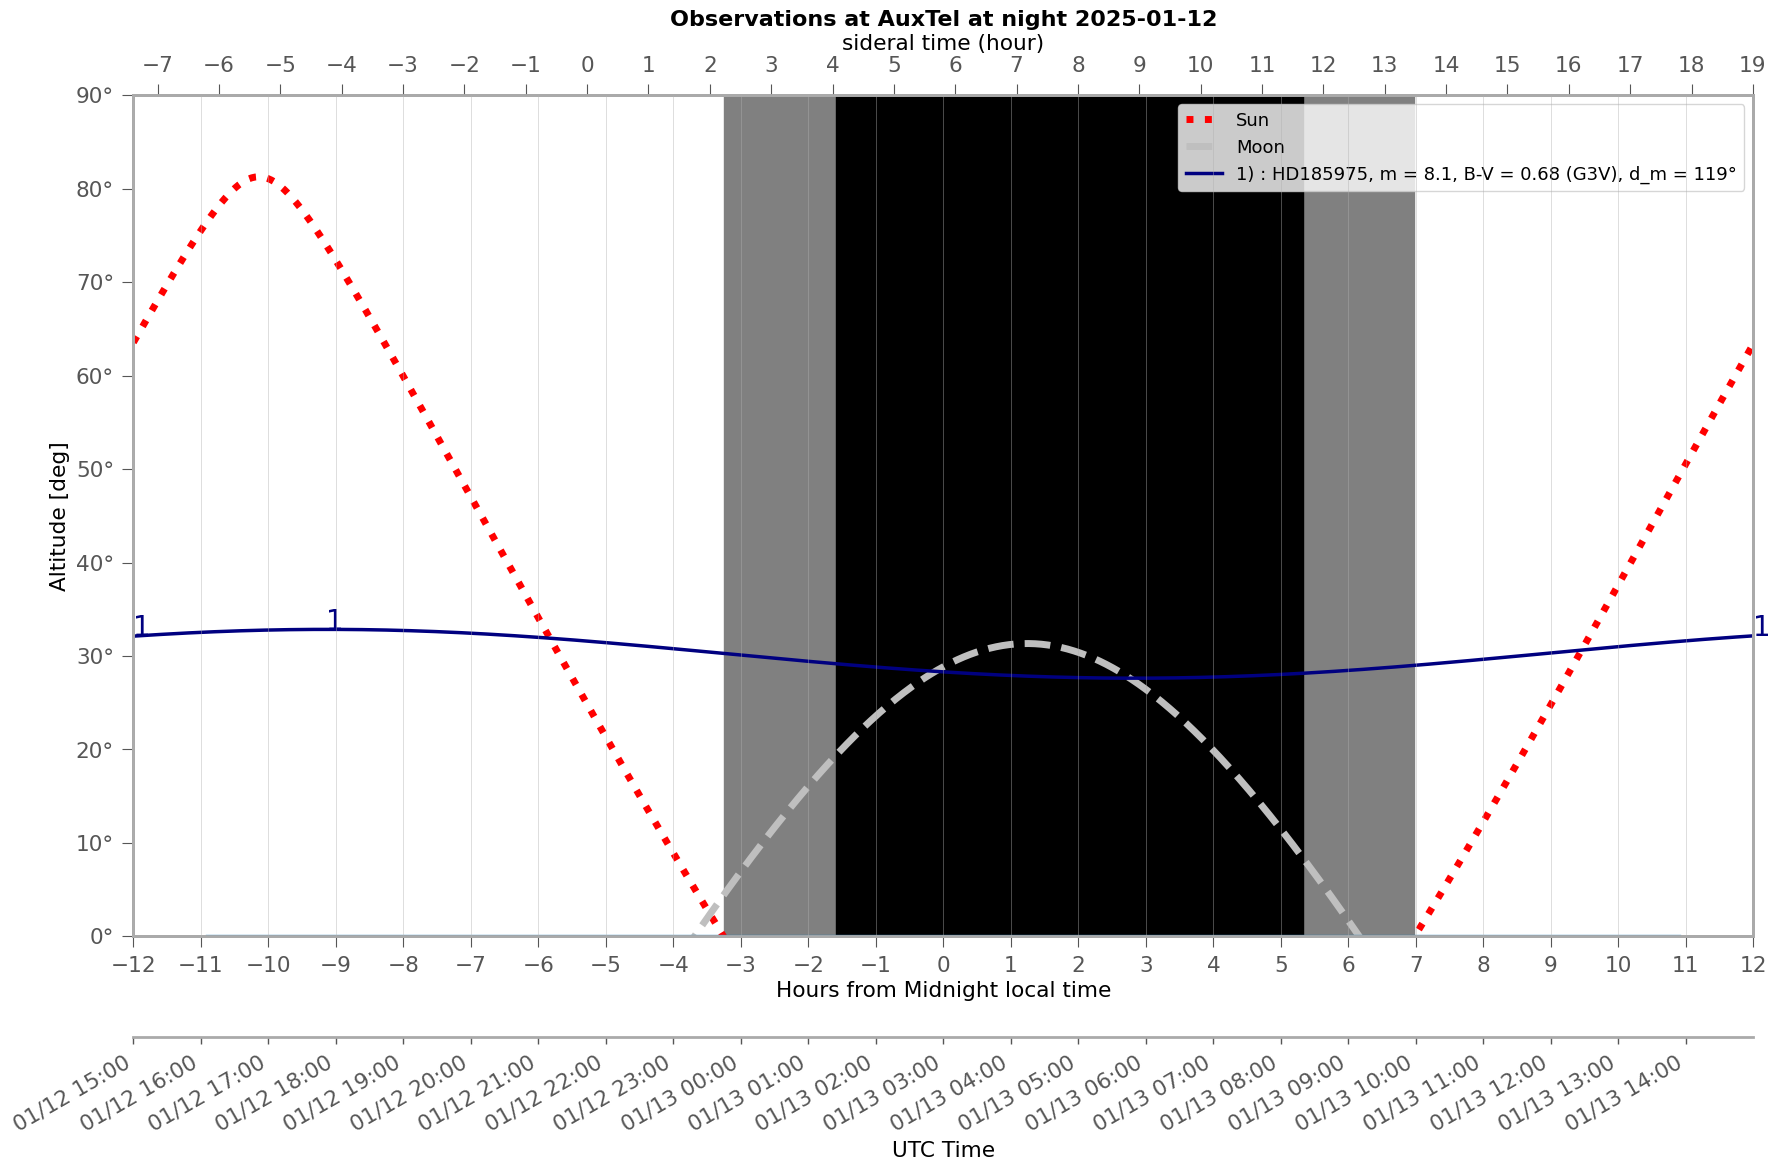

In [91]:
fig = plt.figure(figsize=(18,12),layout="constrained")


# First Axis : target sky trajectories
# ====================================
ax=fig.add_subplot(1,1,1)

# plot sun
ax.plot(delta_midnight, sunaltazs_evening_to_morning.alt, color='r', ls=":",label='Sun',lw=5)
#plot moon
ax.plot(delta_midnight, moonaltazs_evening_to_morning.alt, color=[0.75]*3, ls='--', label='Moon',lw=5)


# loop on selected targets in pandas dataframe t according rank order
for index in range(NTargets):
    
    # select the good row in pandas dataframe from time ordering
    row = (t[t["rank_tmax"] == index]).iloc[0]
    

    # get its tag
    label = str(index+1) + ") : " + row["tag"]
    
    # rank in all_target_altazs_evening_to_morning table
    rank_num = row["rank_num"]
    tmax = row["tmax"]
    altmax = row["alt_max"]
    
    
  
    # plot trajectory
    ax.plot(delta_midnight, all_target_altazs_evening_to_morning[rank_num].alt,label=label, lw=2.5,color=all_colors[index])

    # plot label
    if all_target_altazs_evening_to_morning[rank_num].alt[-1]>0:
        ax.text(delta_midnight[-1], all_target_altazs_evening_to_morning[rank_num].alt[-1], f'{index+1}',color=all_colors[index],fontsize=20)
    if all_target_altazs_evening_to_morning[rank_num].alt[0]>0:
        ax.text(delta_midnight[0], all_target_altazs_evening_to_morning[rank_num].alt[0], f'{index+1}',color=all_colors[index],fontsize=20)
    if altmax>0 :
        ax.text(tmax, altmax, f'{index+1}',color=all_colors[index],fontsize=20)
    


ax.fill_between(delta_midnight, 0*u.deg, 90*u.deg,sunaltazs_evening_to_morning.alt < -0*u.deg, color='0.5', zorder=0)
ax.fill_between(delta_midnight, 0*u.deg, 90*u.deg,sunaltazs_evening_to_morning.alt < -18*u.deg, color='k', zorder=0)

ax.legend(loc='upper right')
ax.set_xlim(-12*u.hour, 12*u.hour)
ax.set_xticks((np.arange(13)*2-12)*u.hour)
ax.set_ylim(0*u.deg, 90*u.deg)
ax.set_xlabel('Hours from Midnight local time')
ax.set_ylabel('Altitude [deg]')
ax.grid(None)
tick_spacing = 1
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
title = "Observations at AuxTel at night " + night_obs_str.split(" ")[0]
ax.set_title(title)
#for label in ax.get_xticklabels(which='major'):
#    label.set(rotation=30, horizontalalignment='right')


# second horizontal axis : Sideral time axis
# ==========================================
ax2 = ax.twiny()
ax2.plot([sideral_times[0].hour,sideral_times[-1].hour],[0,0])
ax2.set_xlabel("sideral time (hour)")
ax2.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax2.grid(None)

# third horizontal axis : UTC time axis
# =====================================

ax3 = ax.twiny()
# Move twinned axis ticks and label from top to bottom
ax3.xaxis.set_ticks_position("bottom")
ax3.xaxis.set_label_position("bottom")
# Offset the twin axis below the host
offset = -0.12
ax3.spines["bottom"].set_position(("axes", offset))

ax3.set_frame_on(True)
ax3.patch.set_visible(False) # mandatory
for sp in ax3.spines.values():
    sp.set_visible(False)
ax3.spines["bottom"].set_visible(True)
fmt = '%m/%d %H:%M'
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter(fmt))
ax3.xaxis.set_major_locator(mdates.HourLocator(interval=1))

curvetoremove, = ax3.plot_date(times_evening_to_morning_datetime, sunaltazs_evening_to_morning.alt, color='r', ls=":",lw=0)
curvetoremove.remove()
ax3.set_xlim(times_evening_to_morning_datetime[0], times_evening_to_morning_datetime[-1])



ax3.tick_params(which='major', width=1.00, length=5)
ax3.tick_params(which='minor', width=0.75, length=2.5)
ax3.grid(True)
#plt.gcf().autofmt_xdate()  # orient date labels at a slant
# slant for this axis
for label in ax3.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')

ax3.set_xlabel("UTC Time")

if FLAG_PRESELECTION_TARGET: 
    figname="AuxtelStarAlt_preselectedcalspec{:4d}_{:d}_{:d}.png".format(NYEAR,NMONTH,NDAY)
else:
    figname="AuxtelStarAlt_visiblecalspec{:4d}_{:d}_{:d}.png".format(NYEAR,NMONTH,NDAY)

plt.tight_layout()
plt.savefig(figname)

plt.show()

# To plot in staralt

https://www.ing.iac.es//Astronomy/telescopes/wht/catformat.html

In [92]:
t_staralt = t[["Star_name","RA","Decl","rank_tmax"]]
t_staralt["equinox"] = np.full(NTargets,"J2000")
t_staralt = t_staralt.sort_values(by = ['rank_tmax'])
t_staralt = t_staralt.drop(['rank_tmax'], axis=1)

/var/folders/79/hrybm_4s0zjd4jsb7lp_trhh0000gp/T/ipykernel_98739/2260111632.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t_staralt["equinox"] = np.full(NTargets,"J2000")


In [93]:
t_staralt

,Star_name,RA,Decl,equinox
0,HD185975,20 28 18.740,-87 28 19.94,J2000


In [94]:
t_staralt.to_csv("staralt.csv",index=False,header=False, sep = " ")

In [95]:
! cat staralt.csv

HD185975 "20 28 18.740" "-87 28 19.94" J2000


# Spheric plot

In [96]:
def makePolarPlot(azimuthsInDegrees, zenithAngles, marker=".",ax=None,
                       title=None, color=None, objName=None,lw=0.5):
    if ax==None:
        _ = plt.figure(figsize=(20, 10))
        ax = plt.subplot(111, polar=True)
        
    ax.plot([a*np.pi/180 for a in azimuthsInDegrees], zenithAngles, marker, c=color, label=objName,lw=lw)
    if title:
        ax.set_title(title, va='bottom')
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    ax.set_rlim(0, 90)
    return ax

/var/folders/79/hrybm_4s0zjd4jsb7lp_trhh0000gp/T/ipykernel_98739/630588586.py:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['N', '', 'E', '', 'S', '', 'W', ''])


Text(0.5, 1.0, 'Observations at AuxTel at night 2025-01-12')

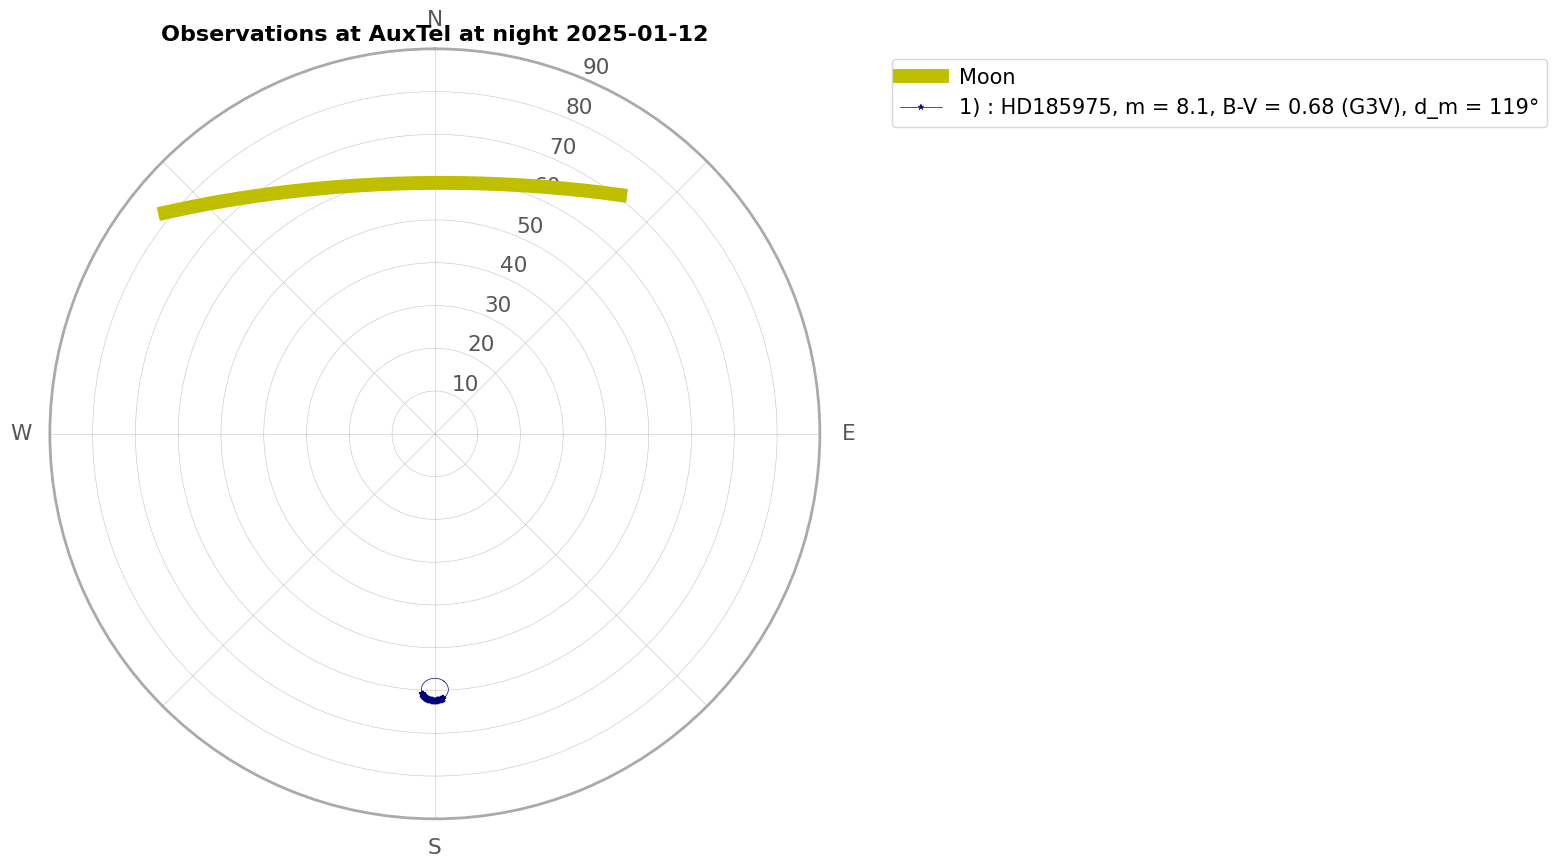

In [97]:
_ = plt.figure(figsize=(20, 10))

ax = plt.subplot(111, polar=True)


darkTimeIndex=[sunaltazs_evening_to_morning.alt < -18*u.deg][0]

# compute zenith and azimuth angles
moon_azimuthsInDegrees = Angle(moonaltazs_evening_to_morning.az).deg
moon_zenithAngles = Angle(moonaltazs_evening_to_morning.zen).deg

#ax=makePolarPlot(moon_azimuthsInDegrees, moon_zenithAngles,ax=ax, marker="--",color="y", title = None, lw=1)

moon_azimuthsInDegreesNight=moon_azimuthsInDegrees[darkTimeIndex]
moon_zenithAnglesNight=moon_zenithAngles[darkTimeIndex]
ax=makePolarPlot(moon_azimuthsInDegreesNight, moon_zenithAnglesNight,ax=ax ,marker="*-",title=None, color = "y",objName="Moon",lw=10)

    
# loop on selected targets in pandas dataframe t according rank order
for index in range(NTargets):
    
    # select the good row in pandas dataframe from time ordering
    row = (t[t["rank_tmax"] == index]).iloc[0]
    

    # get its tag
    label = str(index+1) + ") : " + row["tag"]
    
    # rank in all_target_altazs_evening_to_morning table
    rank_num = row["rank_num"]
    tmax = row["tmax"]
    altmax = row["alt_max"]
    
    
    
    
    
    # compute zenith and azimuth angles
    azimuthsInDegrees=Angle(all_target_altazs_evening_to_morning[rank_num].az).deg
    zenithAngles = Angle(all_target_altazs_evening_to_morning[rank_num].zen).deg
    
    ax=makePolarPlot(azimuthsInDegrees, zenithAngles,ax=ax, marker="-",title=None, color=all_colors[index], lw=0.5)
    
    azimuthsInDegreesNight=azimuthsInDegrees[darkTimeIndex]
    zenithAnglesNight=zenithAngles[darkTimeIndex]
    ax=makePolarPlot(azimuthsInDegreesNight, zenithAnglesNight,ax=ax ,marker="*-",title=None, color=all_colors[index],objName=label,lw=0.5)
    
    thex=zenithAnglesNight[0]*np.sin( (azimuthsInDegreesNight[0]) *np.pi/180.)
    they=zenithAnglesNight[0]*np.cos( (azimuthsInDegreesNight[0])*np.pi/180.)
   
    #plt.text(thex, they,f'{rank}',color=all_colors[rank],fontsize=20)
    
 
ax.legend(bbox_to_anchor=(1.08, 1), prop={'size': 15}, loc='upper left')
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.set_rlim(0, 90)
ax.set_xticklabels(['N', '', 'E', '', 'S', '', 'W', ''])
title = "Observations at AuxTel at night " + night_obs_str.split(" ")[0]
ax.set_title(title)

# Spectra

In [98]:
from getCalspec.getCalspec import *

In [99]:
plt.rcParams["figure.figsize"]=(8,4)

In [100]:
NTargets

1

In [101]:
ncols = 2

if NTargets % ncols == 0:
    nrows = NTargets//ncols+1
else:
    nrows = int(np.floor(NTargets/ncols))+1

In [102]:
nrows

1

In [103]:
XMIN = 300.
XMAX = 1100.

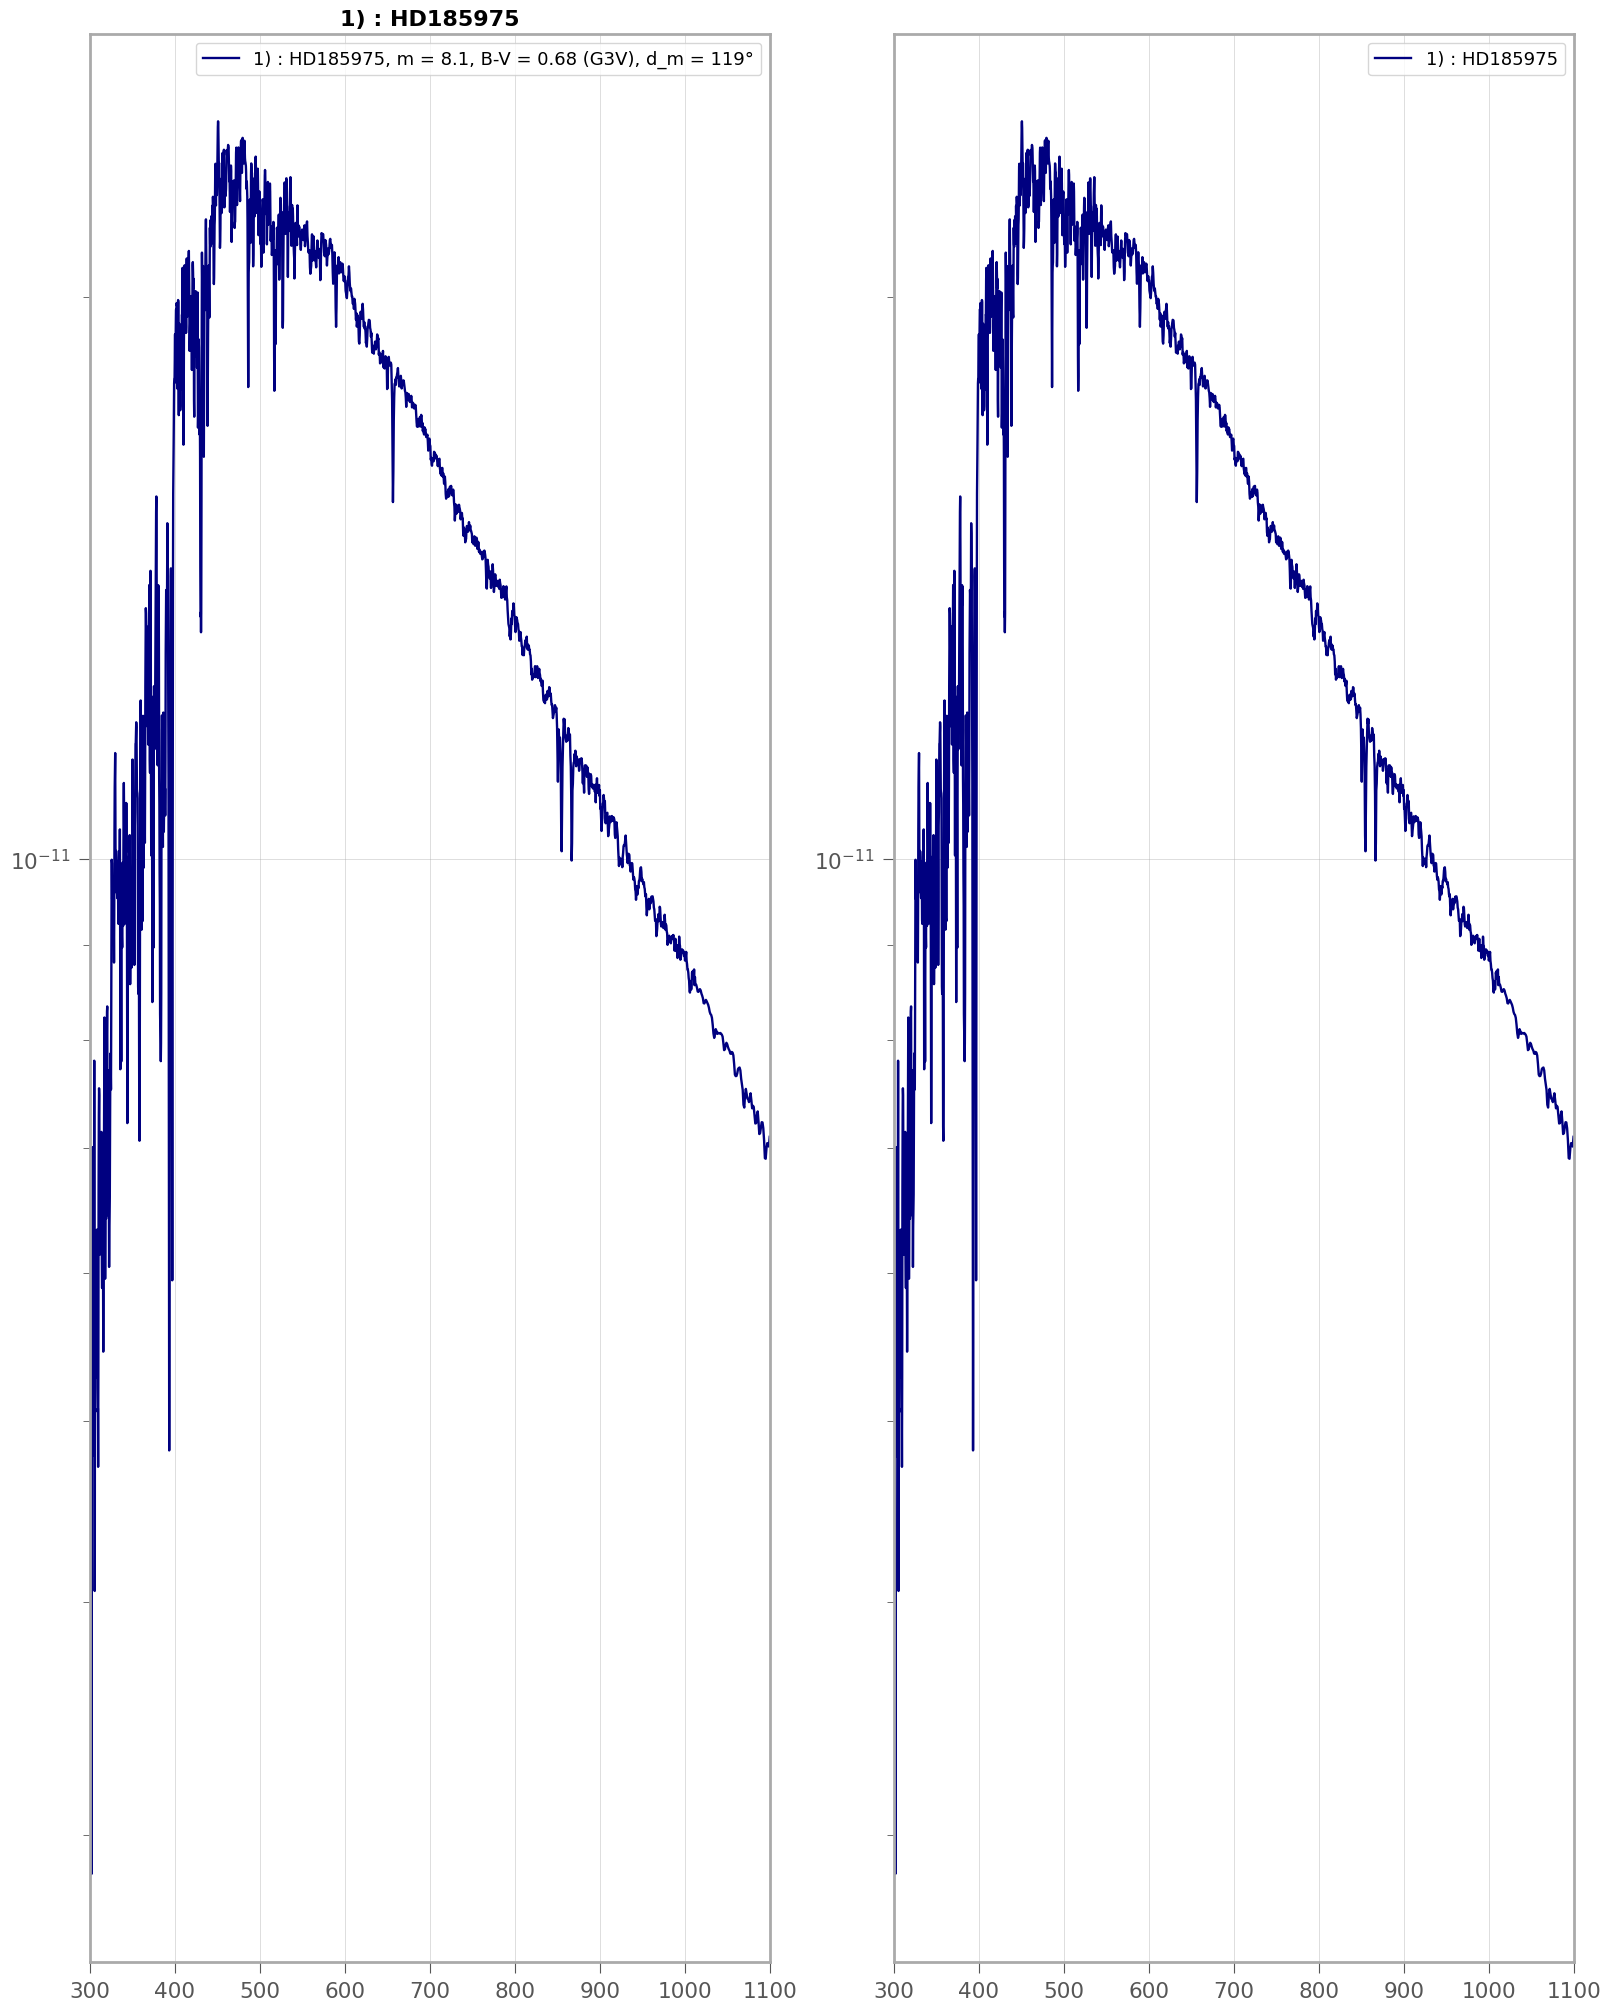

In [104]:
fig, axes= plt.subplots(nrows=nrows,ncols=ncols,sharex=False,figsize=(16,20), layout='constrained')

# loop on selected targets in pandas dataframe t according rank order
all_wl = []
all_fl = []
all_obj= []

for index, ax in enumerate(axes.flat):
    
    if index < NTargets:
    
        # select the good row in pandas dataframe from time ordering
        row = (t[t["rank_tmax"] == index]).iloc[0]
    

        # get its tag
        label = str(index+1) + ") : " + row["tag"]
    
        # rank in all_target_altazs_evening_to_morning table
        target_name = row["Star_name"]
    
        test = is_calspec(target_name)
    
        if test:
        
            c = Calspec(target_name)
            c.get_spectrum_fits_filename()  # download the fits file
            tab = c.get_spectrum_table()  # download and return an Astropy table
            arr = c.get_spectrum_numpy()  # download and return a dictionnary of numpy arrays with units
            #c.plot_spectrum()  # download and plot the spectrum
            
            wl = arr['WAVELENGTH'].to_value()/10.
            fl = arr['FLUX'].to_value()*10.
            
            indexes = np.where(np.logical_and(wl>=XMIN,wl<=XMAX))[0]
            
            wl = wl[indexes]
            fl = fl[indexes]
            ax.plot(wl,fl,"-",color=all_colors[index],label=label)
            ax.set_yscale("log")
            title = f"{index+1}) : {target_name}"
            ax.set_title(title)
            ax.legend()
            ax.set_xlim(XMIN,XMAX)
            
            all_wl.append(wl)
            all_fl.append(fl)
            all_obj.append(title)
        else:
            print(f"{target_name} NOT A CALSPEC")
    else:
        if index == NTargets:
            for j in range(NTargets):
                ax.plot(all_wl[j], all_fl[j],'-',color=all_colors[j],label=all_obj[j] )
            ax.set_yscale("log")
            ax.legend()
            ax.set_xlim(XMIN,XMAX)
#plt.tight_layout()            

Text(0, 0.5, 'FLAM')

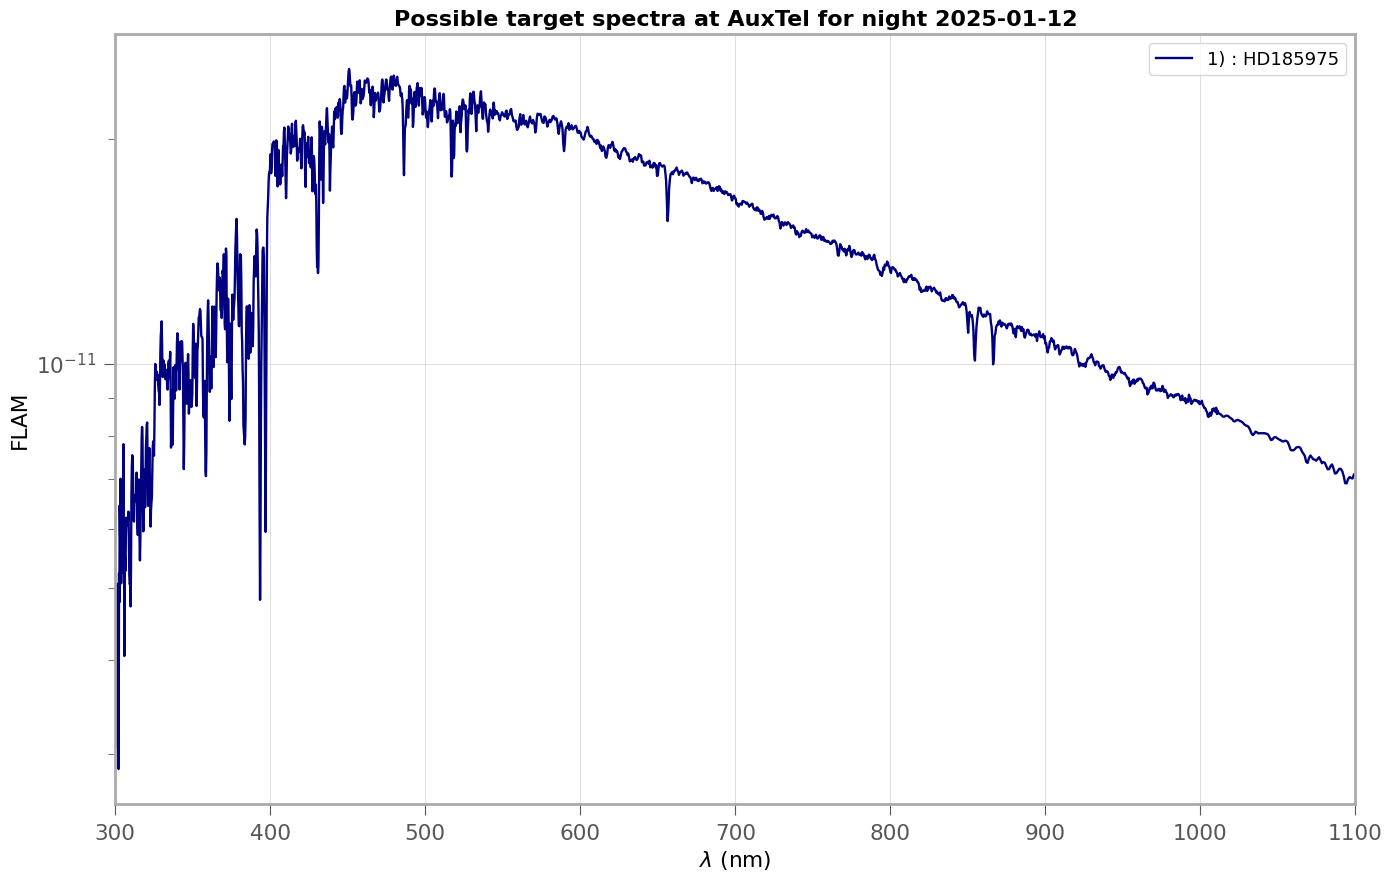

In [105]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(16,10))

for j in range(NTargets):
    ax.plot(all_wl[j], all_fl[j],'-',color=all_colors[j],label=all_obj[j] )
    ax.set_yscale("log")
    ax.legend()
    ax.set_xlim(XMIN,XMAX)
title = "Possible target spectra at AuxTel for night " + night_obs_str.split(" ")[0]
ax.set_title(title) 
ax.set_xlabel("$\\lambda$ (nm)")
ax.set_ylabel("FLAM")

## Choose spectra

- **Select by hands the target one want to select**

In [106]:
index_chosen_spectra = np.array([10,12,15]) -1

/var/folders/79/hrybm_4s0zjd4jsb7lp_trhh0000gp/T/ipykernel_98739/1560316203.py:93: MatplotlibDeprecationWarning: The plot_date function was deprecated in Matplotlib 3.9 and will be removed in 3.11. Use plot instead.
  curvetoremove, = ax3.plot_date(times_evening_to_morning_datetime, sunaltazs_evening_to_morning.alt, color='r', ls=":",lw=0)
/var/folders/79/hrybm_4s0zjd4jsb7lp_trhh0000gp/T/ipykernel_98739/1560316203.py:105: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


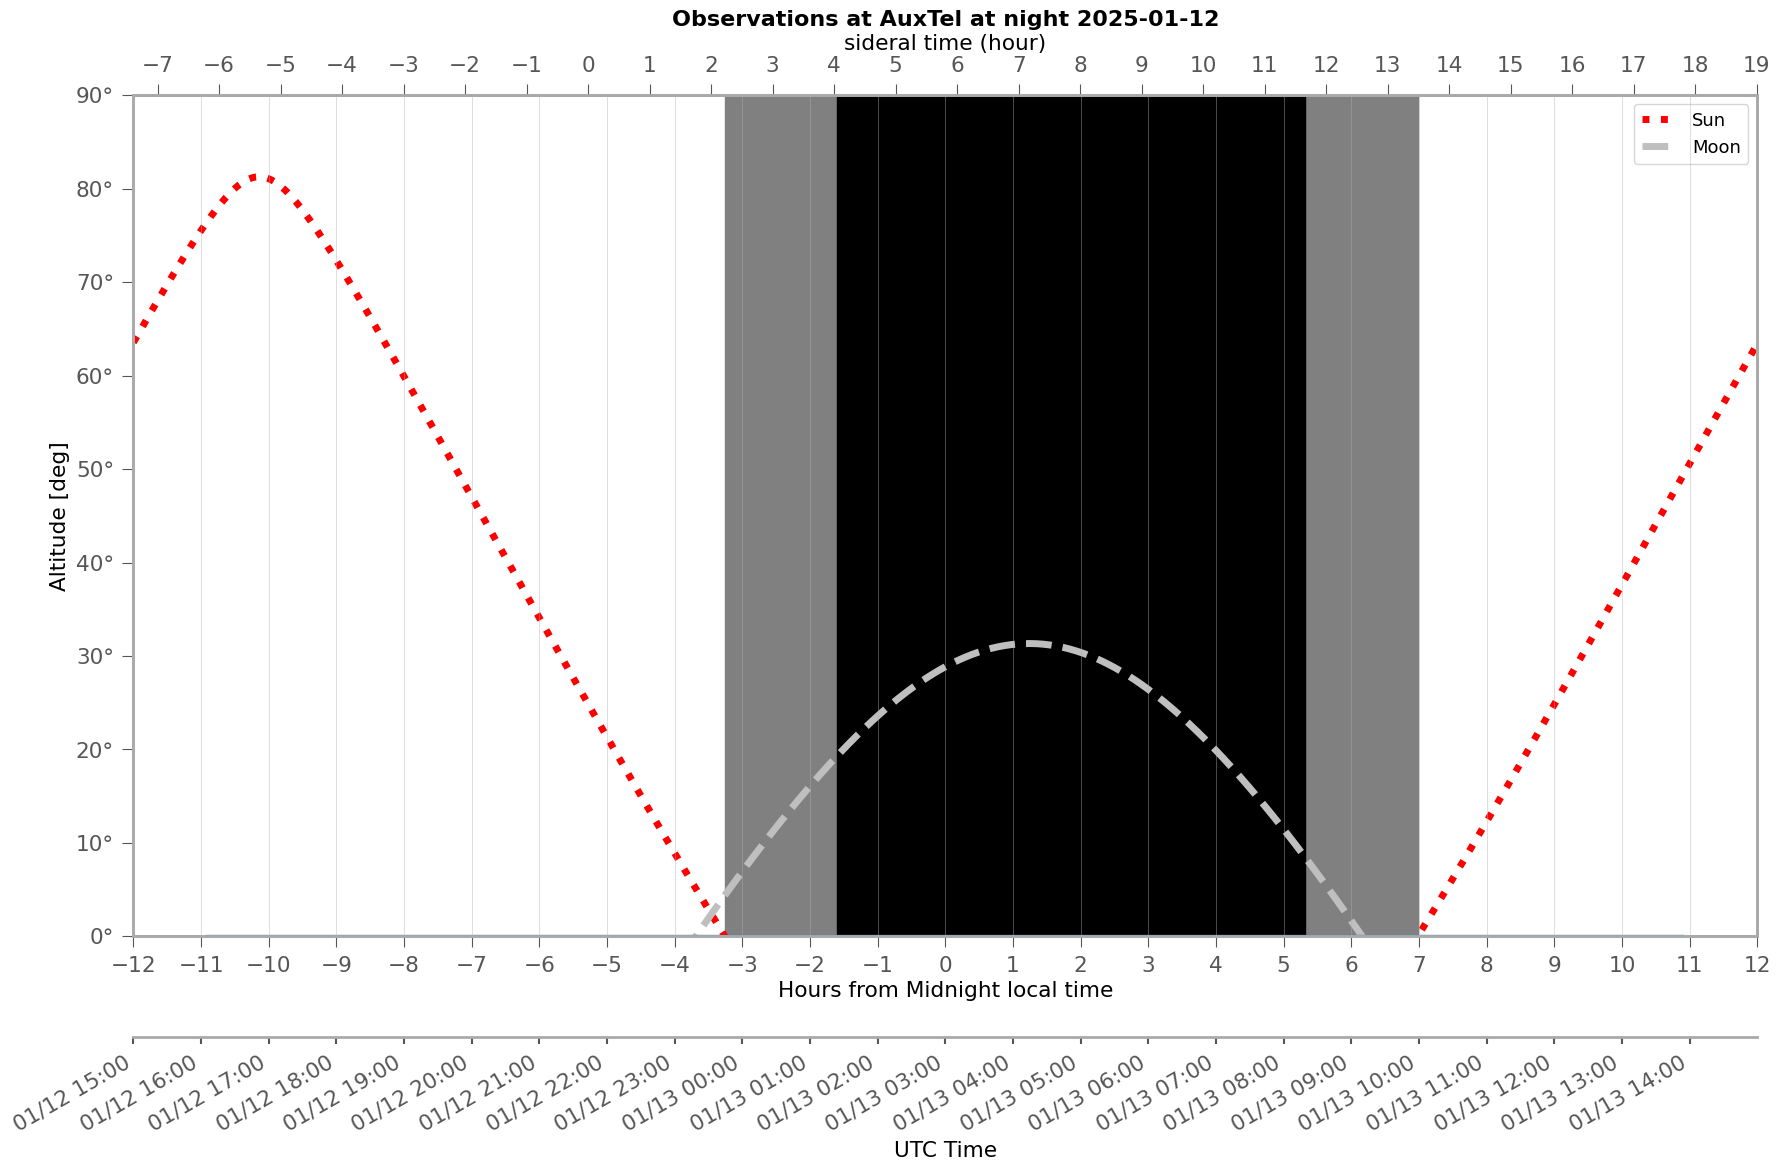

In [107]:
fig = plt.figure(figsize=(18,12),layout="constrained")
ax=fig.add_subplot(1,1,1)


# First Axis : target sky trajectories
# ====================================

# plot sun
ax.plot(delta_midnight, sunaltazs_evening_to_morning.alt, color='r', ls=":",label='Sun',lw=5)
#plot moon
ax.plot(delta_midnight, moonaltazs_evening_to_morning.alt, color=[0.75]*3, ls='--', label='Moon',lw=5)


# loop on selected targets in pandas dataframe t according rank order
for index in range(NTargets):
    
    if index not in index_chosen_spectra:
        continue
    
    # select the good row in pandas dataframe from time ordering
    row = (t[t["rank_tmax"] == index]).iloc[0]
    

    # get its tag
    label = str(index+1) + ") : " + row["tag"]
    
    # rank in all_target_altazs_evening_to_morning table
    rank_num = row["rank_num"]
    tmax = row["tmax"]
    altmax = row["alt_max"]
    
    
  
    # plot trajectory
    ax.plot(delta_midnight, all_target_altazs_evening_to_morning[rank_num].alt,label=label, lw=2.5,color=all_colors[index])

    # plot label
    if all_target_altazs_evening_to_morning[rank_num].alt[-1]>0:
        ax.text(delta_midnight[-1], all_target_altazs_evening_to_morning[rank_num].alt[-1], f'{index+1}',color=all_colors[index],fontsize=20)
    if all_target_altazs_evening_to_morning[rank_num].alt[0]>0:
        ax.text(delta_midnight[0], all_target_altazs_evening_to_morning[rank_num].alt[0], f'{index+1}',color=all_colors[index],fontsize=20)
    if altmax>0 :
        ax.text(tmax, altmax, f'{index+1}',color=all_colors[index],fontsize=20)
    


ax.fill_between(delta_midnight, 0*u.deg, 90*u.deg,sunaltazs_evening_to_morning.alt < -0*u.deg, color='0.5', zorder=0)
ax.fill_between(delta_midnight, 0*u.deg, 90*u.deg,sunaltazs_evening_to_morning.alt < -18*u.deg, color='k', zorder=0)

ax.legend(loc='upper right')
ax.set_xlim(-12*u.hour, 12*u.hour)
ax.set_xticks((np.arange(13)*2-12)*u.hour)
ax.set_ylim(0*u.deg, 90*u.deg)
ax.set_xlabel('Hours from Midnight local time')
ax.set_ylabel('Altitude [deg]')
ax.grid(None)
tick_spacing = 1
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
title = "Observations at AuxTel at night " + night_obs_str.split(" ")[0]
ax.set_title(title)


#Second axis : Sideral time axis
# ==============================

ax2 = ax.twiny()
ax2.plot([sideral_times[0].hour,sideral_times[-1].hour],[0,0])
ax2.set_xlabel("sideral time (hour)")
ax2.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax2.grid(None)


# Third horizontal axis : UTC time
# ================================

ax3 = ax.twiny()
# Move twinned axis ticks and label from top to bottom
ax3.xaxis.set_ticks_position("bottom")
ax3.xaxis.set_label_position("bottom")
# Offset the twin axis below the host
offset = -0.12
ax3.spines["bottom"].set_position(("axes", offset))

ax3.set_frame_on(True)
ax3.patch.set_visible(False) # mandatory
for sp in ax3.spines.values():
    sp.set_visible(False)
ax3.spines["bottom"].set_visible(True)
fmt = '%m/%d %H:%M'
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter(fmt))
ax3.xaxis.set_major_locator(mdates.HourLocator(interval=1))

curvetoremove, = ax3.plot_date(times_evening_to_morning_datetime, sunaltazs_evening_to_morning.alt, color='r', ls=":",lw=0)
curvetoremove.remove()
ax3.set_xlim(times_evening_to_morning_datetime[0], times_evening_to_morning_datetime[-1])

ax3.tick_params(which='major', width=1.50, length=5)
ax3.tick_params(which='minor', width=0.75, length=2.5)
ax3.grid(True)
# rotation of labels
for label in ax3.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
ax3.set_xlabel("UTC Time")

plt.tight_layout()

figname="AuxtelStarAlt_CalspecSpectraSelected{:4d}_{:d}_{:d}.png".format(NYEAR,NMONTH,NDAY)

plt.savefig(figname)
plt.show()